# Data Analysis

In [2]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

## Data Load

In [3]:
db = "HAM"
root = f"../../dataset/IEEE/{db}/"

df = pd.DataFrame()
tmp = pd.read_csv(f"{root}exp/test_df_HAM10000_CNN.csv")
tmp["model"] = "CNN"
tmp["dataset"] = "HAM10000"
df = pd.concat([df, tmp], axis=0)

tmp = pd.read_csv(f"{root}exp/test_df_HAM10000_ResNet.csv")
tmp["model"] = "ResNet"
tmp["dataset"] = "HAM10000"
df = pd.concat([df, tmp], axis=0)

db = "FITZ"
root = f"../../dataset/IEEE/{db}/"

tmp = pd.read_csv(f"{root}exp/test_df_Fitzpatrick17K_CNN.csv")
tmp["model"] = "CNN"
tmp["dataset"] = "Fitzpatrick17K"
df = pd.concat([df, tmp], axis=0)

tmp = pd.read_csv(f"{root}exp/test_df_Fitzpatrick17K_ResNet.csv")
tmp["model"] = "ResNet"
tmp["dataset"] = "Fitzpatrick17K"
df = pd.concat([df, tmp], axis=0)

## Categorical skin tone

In [4]:
# Extract attack success rate columns
success_rate_columns = [col for col in df.columns if "success" in col]

# modelとdatasetのユニークな組み合わせを取得
unique_combinations = df[["model", "dataset"]].drop_duplicates()

# SKin tone
skin_tone_order = ["Very Light", "Light", "Intermediate", "Tan", "Brown", "Dark"]

In [5]:
def create_categorical_dataframe(df):
    df_cate = df.groupby(["model", "dataset", "skin tone"])[success_rate_columns].mean().reset_index()
    columns = ["model", "dataset", "skin tone"]
    columns.extend(success_rate_columns)
    df_cate.columns = columns
    return df_cate

df_cate = create_categorical_dataframe(df)

In [6]:
for i, (_, row) in enumerate(unique_combinations.iterrows()):
    model = row["model"]
    dataset = row["dataset"]
    subset = df[(df["model"] == model) & (df["dataset"] == dataset)]

    print(f"{dataset} - {model}")
    print(subset.groupby("skin tone").size())

HAM10000 - CNN
skin tone
Brown              5
Dark               8
Intermediate      53
Light            124
Tan               29
Very Light      1345
dtype: int64
HAM10000 - ResNet
skin tone
Brown              5
Dark               8
Intermediate      53
Light            124
Tan               29
Very Light      1345
dtype: int64
Fitzpatrick17K - CNN
skin tone
Brown            63
Dark             16
Intermediate    205
Light           259
Tan             135
Very Light      186
dtype: int64
Fitzpatrick17K - ResNet
skin tone
Brown            63
Dark             16
Intermediate    205
Light           259
Tan             135
Very Light      186
dtype: int64


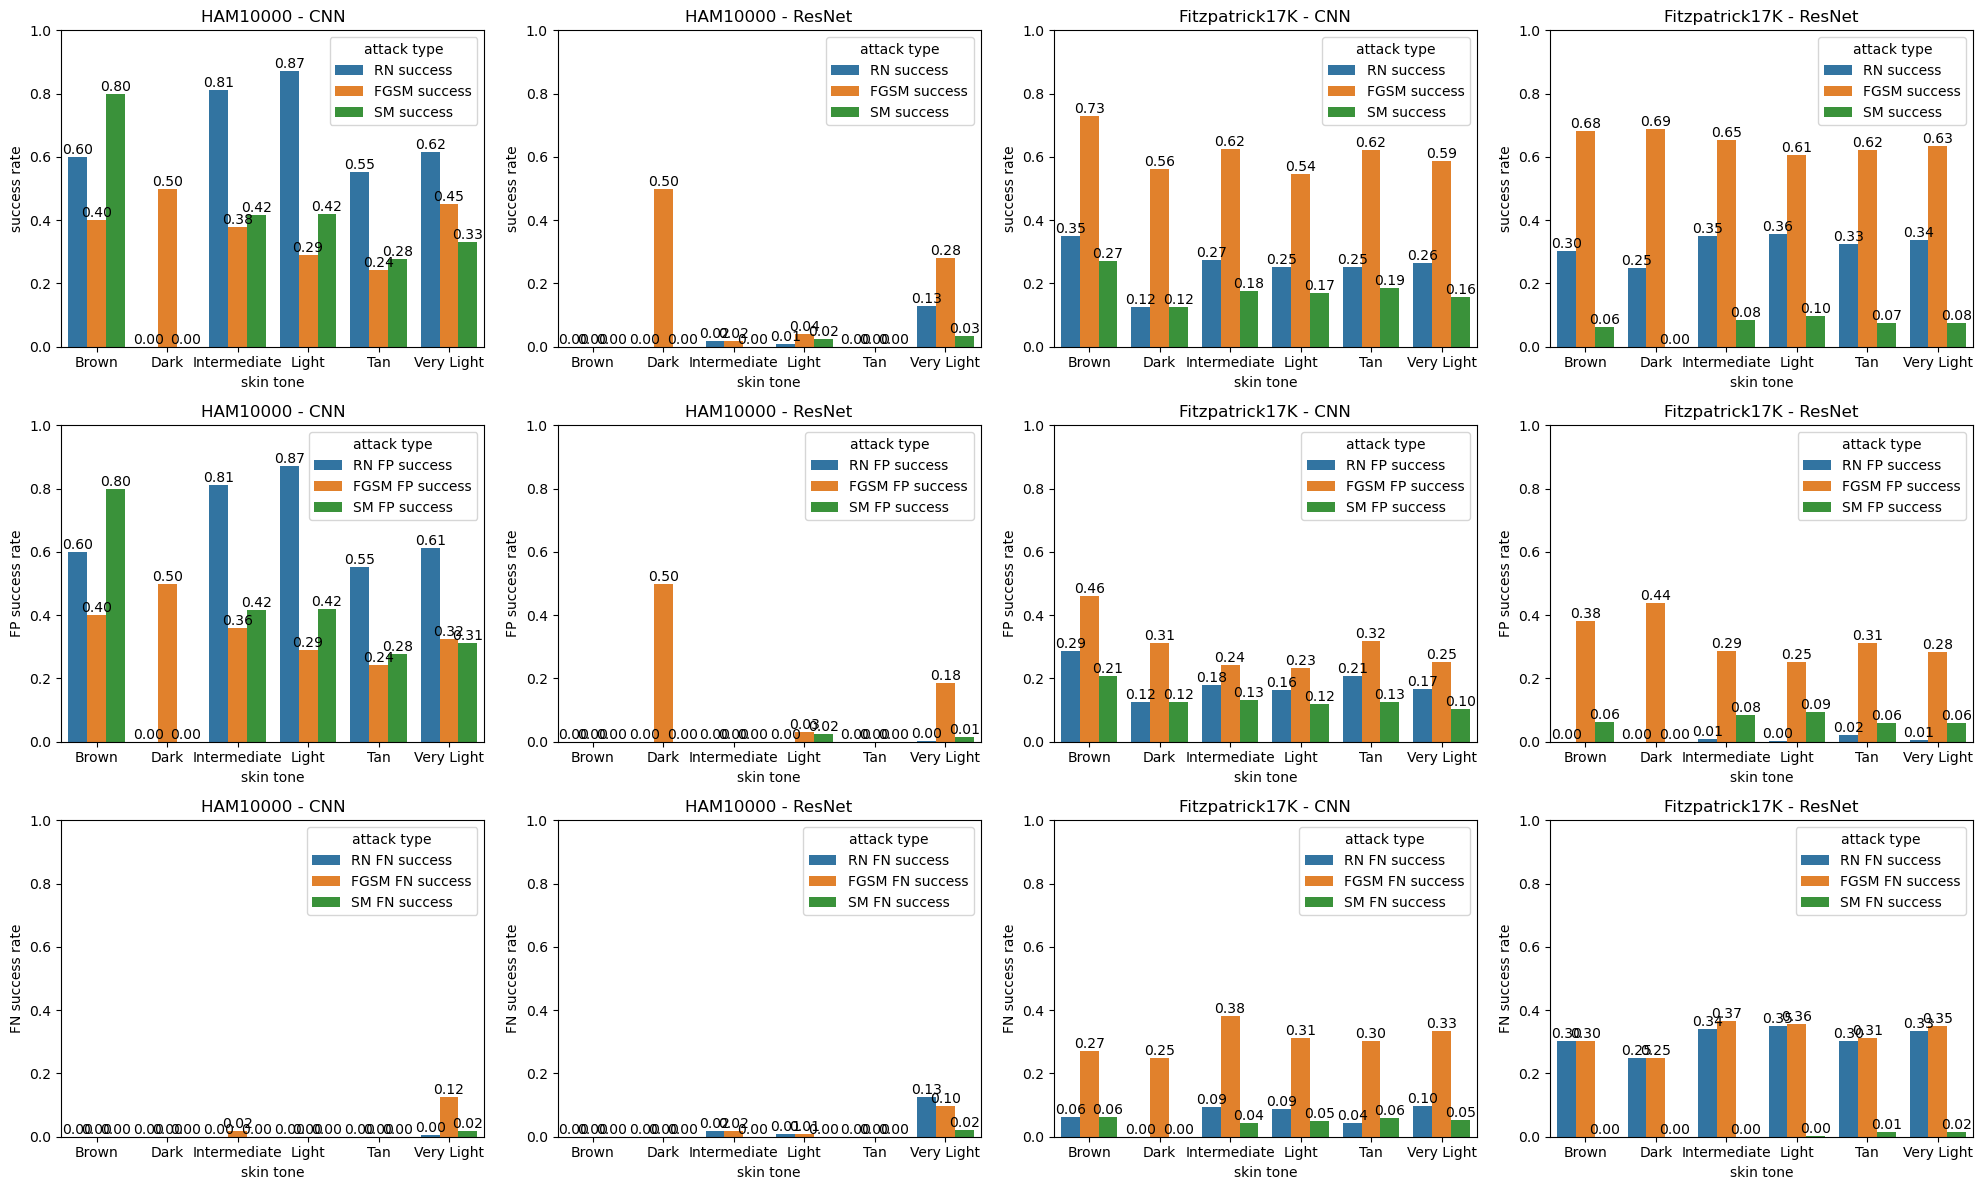

In [7]:
fig, ax = plt.subplots(3, 4, figsize=(20, 12))

for i, (_, row) in enumerate(unique_combinations.iterrows()):
    
    model = row["model"]
    dataset = row["dataset"]
    subset = df_cate[(df_cate["model"] == model) & (df_cate["dataset"] == dataset)]
    
    subset_melt = subset.melt(
        id_vars = "skin tone",
        var_name = "attack type",
        value_name = "success rate",
        value_vars = ["RN success", "FGSM success", "SM success"]
    )

    p = sns.barplot(subset_melt, x="skin tone", y="success rate", hue="attack type", ax=ax[0, i])
    p.set_title(f"{dataset} - {model}")
    p.set_ylim(0, 1)

    for container in p.containers:
        p.bar_label(container, fmt='%.2f')

    subset_melt = subset.melt(
        id_vars = "skin tone",
        var_name = "attack type",
        value_name = "FP success rate",
        value_vars = ["RN FP success", "FGSM FP success", "SM FP success"]
    )

    p = sns.barplot(subset_melt, x="skin tone", y="FP success rate", hue="attack type", ax=ax[1, i])
    p.set_title(f"{dataset} - {model}")
    p.set_ylim(0, 1)

    for container in p.containers:
        p.bar_label(container, fmt='%.2f')

    subset_melt = subset.melt(
        id_vars = "skin tone",
        var_name = "attack type",
        value_name = "FN success rate",
        value_vars = ["RN FN success", "FGSM FN success", "SM FN success"]
    )

    p = sns.barplot(subset_melt, x="skin tone", y="FN success rate", hue="attack type", ax=ax[2, i])
    p.set_title(f"{dataset} - {model}")
    p.set_ylim(0, 1)

    for container in p.containers:
        p.bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()


## Numerical skin color

In [8]:
def create_small_batch(df, col, batch_size = 5):
    
    df_success = pd.DataFrame()
    
    for _, row in unique_combinations.iterrows():
        model = row["model"]
        dataset = row["dataset"]
    
        df_sorted = df[(df["model"] == model) & (df["dataset"] == dataset)]
        df_sorted = df_sorted.sort_values(by=col).reset_index()
        
        df_sorted["batch"] = 0
        total_rows = len(df_sorted)
        
        i = 0
        for start_idx in range(0, total_rows, batch_size):
            end_idx = start_idx + batch_size
            df_sorted.iloc[start_idx:end_idx, df_sorted.columns.get_loc("batch")] = i
            i = i + 1
    
        df_success = pd.concat([df_success, df_sorted], axis=0)

    success_rate_list = [col]
    success_rate_list.extend(success_rate_columns)
    df_group = df_success.groupby(["model", "dataset", "batch"])[success_rate_list].mean().reset_index()
    columns = ["model", "dataset", f"{col} batch"]
    columns.extend(success_rate_list)
    df_group.columns = columns
    return df_group

In [9]:
batch_size = 25
df_ita_batch = create_small_batch(df, "mean ita", batch_size)
df_distance_batch = create_small_batch(df, "distance", batch_size)

In [10]:
# col is numerical type
def plot_correlation(df, col):
    figure, ax = plt.subplots(1, 4, figsize=(32, 4))
    for i, (_, row) in enumerate(unique_combinations.iterrows()):
        
        model = row["model"]
        dataset = row["dataset"]
        subset = df[(df["model"] == model) & (df["dataset"] == dataset)]
    
        correlation_list = [col]
        correlation_list.extend(success_rate_columns)
        correlation_matrix = subset[correlation_list].corr()
        correlation_matrix = correlation_matrix.fillna(0)
        p = sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, ax=ax[i])
        p.set_title(f"{dataset} - {model}")

    plt.show()

In [11]:
# col is numerical type
def plot_correlation_dataframe(df, col):

    for i, (_, row) in enumerate(unique_combinations.iterrows()):
        
        model = row["model"]
        dataset = row["dataset"]
        subset = df[(df["model"] == model) & (df["dataset"] == dataset)]

        print(f"{dataset} - {model}")
        
        correlation_list = [col]
        correlation_list.extend(success_rate_columns)
        correlation_matrix = subset[correlation_list].corr()
        correlation_matrix
        display(correlation_matrix)

In [12]:
def plot_scatter_correlation(df, col):
    figure, ax = plt.subplots(3, 4, figsize=(20, 12))
    
    for i, (_, row) in enumerate(unique_combinations.iterrows()):
        
        model = row["model"]
        dataset = row["dataset"]
        subset = df[(df["model"] == model) & (df["dataset"] == dataset)]
    
        alpha = 0.3
        ax[0, i].scatter(subset[col], subset["RN success"], label="RN success", alpha=alpha)
        ax[0, i].scatter(subset[col], subset["FGSM success"], label="FGSM success", alpha=alpha)
        ax[0, i].scatter(subset[col], subset["SM success"], label="SM success", alpha=alpha)
        ax[1, i].scatter(subset[col], subset["RN FP success"], label="RN FP success", alpha=alpha)
        ax[1, i].scatter(subset[col], subset["FGSM FP success"], label="FGSM FP success", alpha=alpha)
        ax[1, i].scatter(subset[col], subset["SM FP success"], label="SM FP success", alpha=alpha)
        ax[2, i].scatter(subset[col], subset["RN FN success"], label="RN FN success", alpha=alpha)
        ax[2, i].scatter(subset[col], subset["FGSM FN success"], label="FGSM FN success", alpha=alpha)
        ax[2, i].scatter(subset[col], subset["SM FN success"], label="SM FN success", alpha=alpha)
        ax[0, i].set_title(f"{dataset} - {model}")
        ax[2, i].set_xlabel(f"{col}")
        ax[0, i].set_ylabel("Success Rate")
        ax[1, i].set_ylabel("FP Success Rate")
        ax[2, i].set_ylabel("FN Success Rate")
    
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
def plot_scatter_correlation_with_regression(df, col):
    
    fig, ax = plt.subplots(3, 4, figsize=(20, 12))
    
    for i, (_, row) in enumerate(unique_combinations.iterrows()):
        model = row["model"]
        dataset = row["dataset"]
        subset = df[(df["model"] == model) & (df["dataset"] == dataset)]
    
        alpha = 0.3
        
        for j, metric in enumerate(["RN success", "FGSM success", "SM success"]):
            ax[0, i].scatter(subset[col], subset[metric], label=metric, alpha=alpha)
            slope, intercept, _, _, _ = linregress(subset[col], subset[metric])
            ax[0, i].plot(subset[col], slope * subset[col] + intercept)
    
        for j, metric in enumerate(["RN FP success", "FGSM FP success", "SM FP success"]):
            ax[1, i].scatter(subset[col], subset[metric], label=metric, alpha=alpha)
            slope, intercept, _, _, _ = linregress(subset[col], subset[metric])
            ax[1, i].plot(subset[col], slope * subset[col] + intercept)
    
        for j, metric in enumerate(["RN FN success", "FGSM FN success", "SM FN success"]):
            ax[2, i].scatter(subset[col], subset[metric], label=metric, alpha=alpha)
            slope, intercept, _, _, _ = linregress(subset[col], subset[metric])
            ax[2, i].plot(subset[col], slope * subset[col] + intercept)
    
        ax[0, i].set_title(f"{dataset} - {model}")
        ax[2, i].set_xlabel(f"{col}")
        ax[0, i].set_ylabel("Success Rate")
        ax[0, i].set_ylim(0, 1)
        ax[1, i].set_ylabel("FP Success Rate")
        ax[1, i].set_ylim(0, 1)
        ax[2, i].set_ylabel("FN Success Rate")
        ax[2, i].set_ylim(0, 1)
    
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

In [14]:
def plot_kde_correlation(df, col):
    
    fig, ax = plt.subplots(3, 4, figsize=(20, 12))

    for i, (_, row) in enumerate(unique_combinations.iterrows()):
        
        model = row["model"]
        dataset = row["dataset"]
        subset = df[(df["model"] == model) & (df["dataset"] == dataset)]
    
        alpha = 0.8
        
        sns.kdeplot(x=subset[col], y=subset["RN success"], cmap="Blues", ax=ax[0, i], fill=True, alpha=alpha)
        sns.kdeplot(x=subset[col], y=subset["FGSM success"], cmap="Oranges", ax=ax[0, i], fill=True, alpha=alpha)
        sns.kdeplot(x=subset[col], y=subset["SM success"], cmap="Greens", ax=ax[0, i], fill=True, alpha=alpha)
        
        sns.kdeplot(x=subset[col], y=subset["RN FP success"], cmap="Blues", ax=ax[1, i], fill=True, alpha=alpha)
        sns.kdeplot(x=subset[col], y=subset["FGSM FP success"], cmap="Oranges", ax=ax[1, i], fill=True, alpha=alpha)
        sns.kdeplot(x=subset[col], y=subset["SM FP success"], cmap="Greens", ax=ax[1, i], fill=True, alpha=alpha)
        
        sns.kdeplot(x=subset[col], y=subset["RN FN success"], cmap="Blues", ax=ax[2, i], fill=True, alpha=alpha)
        sns.kdeplot(x=subset[col], y=subset["FGSM FN success"], cmap="Oranges", ax=ax[2, i], fill=True, alpha=alpha)
        sns.kdeplot(x=subset[col], y=subset["SM FN success"], cmap="Greens", ax=ax[2, i], fill=True, alpha=alpha)
    
        ax[0, i].set_title(f"{dataset} - {model}")
        ax[0, i].set_ylabel("Success Rate")
        ax[0, i].set_ylim(0, 1)
        ax[1, i].set_ylabel("FP Success Rate")
        ax[1, i].set_ylim(0, 1)
        ax[2, i].set_ylabel("FN Success Rate")
        ax[2, i].set_ylim(0, 1)
    
    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

## Scalar skin color

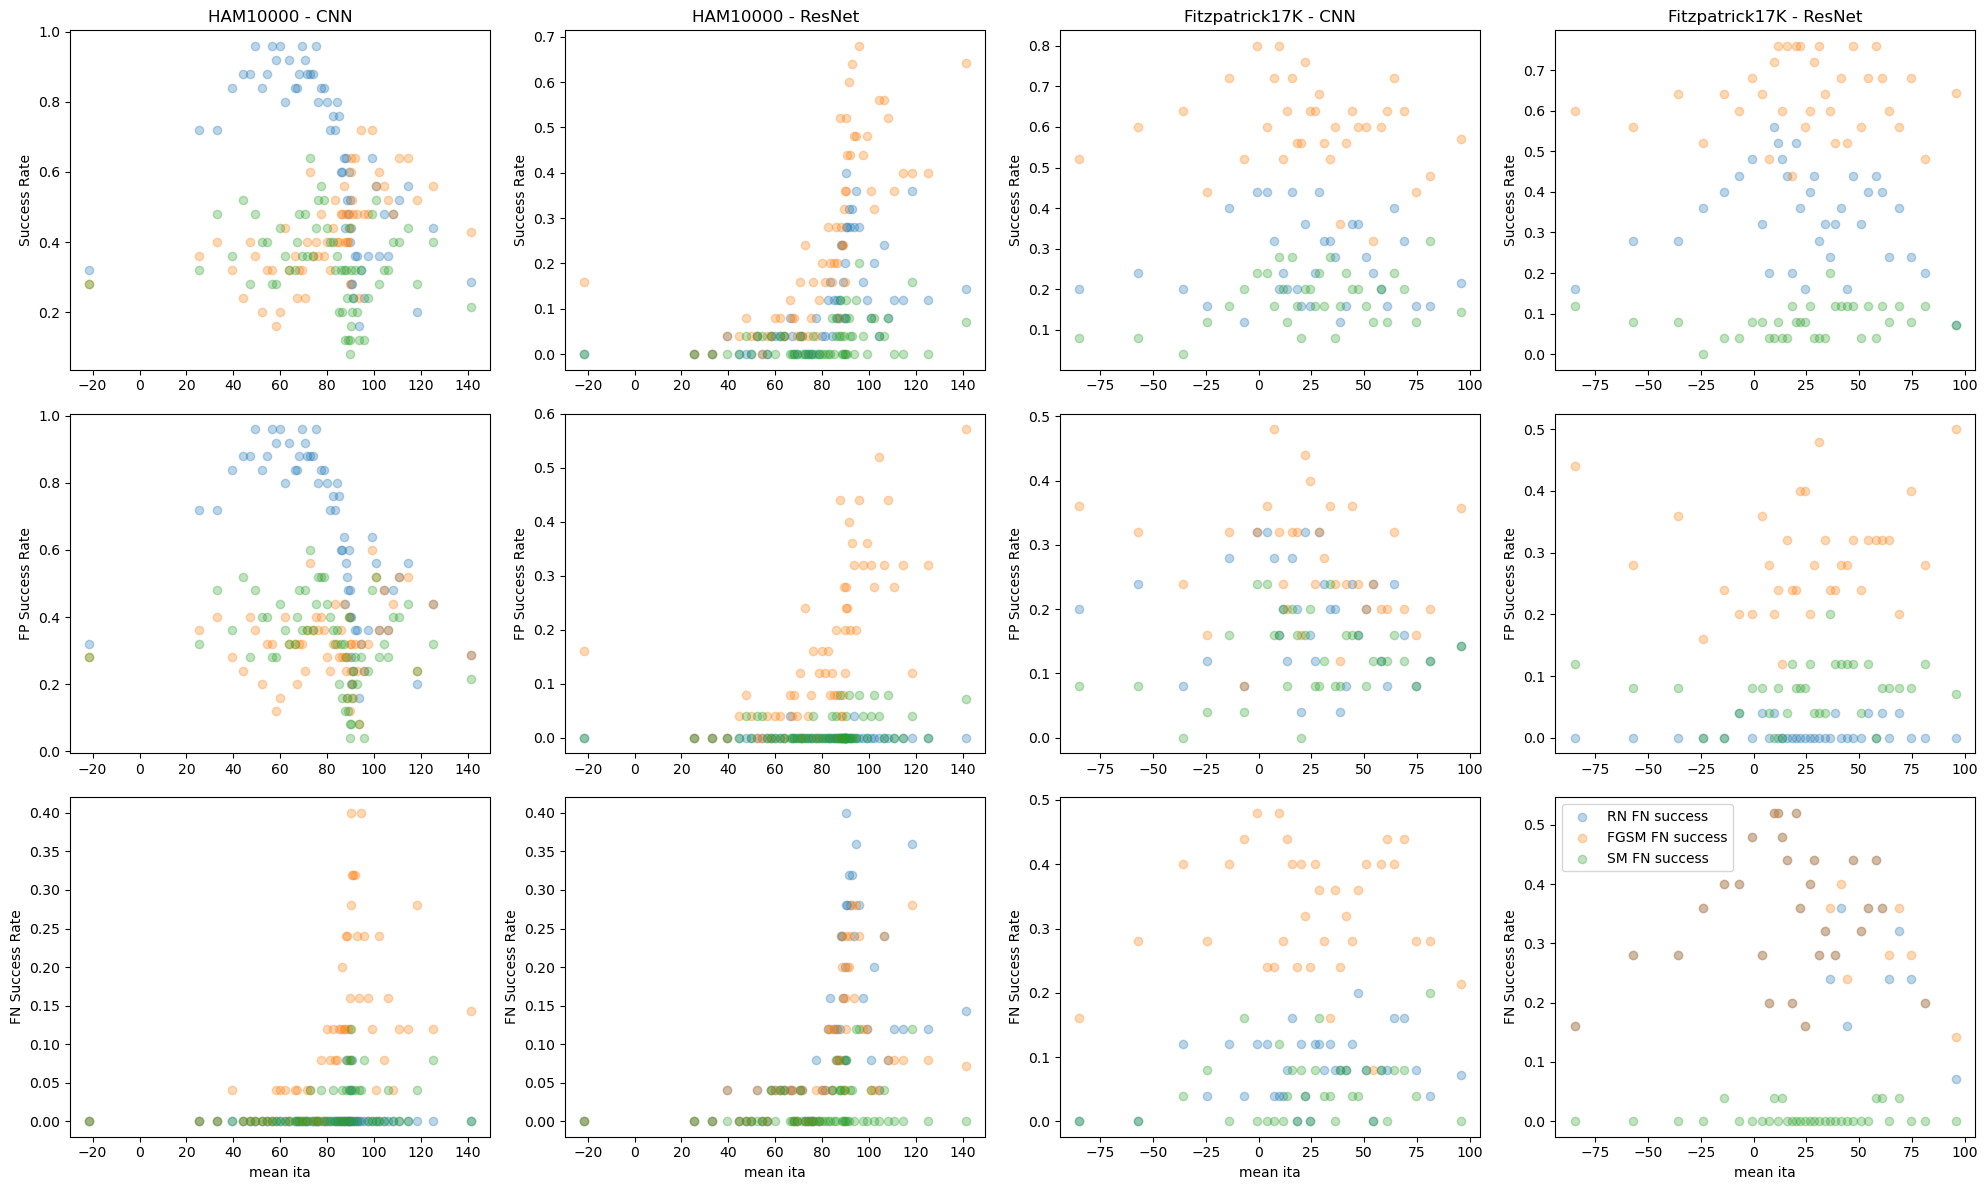

In [15]:
plot_scatter_correlation(df_ita_batch, "mean ita")

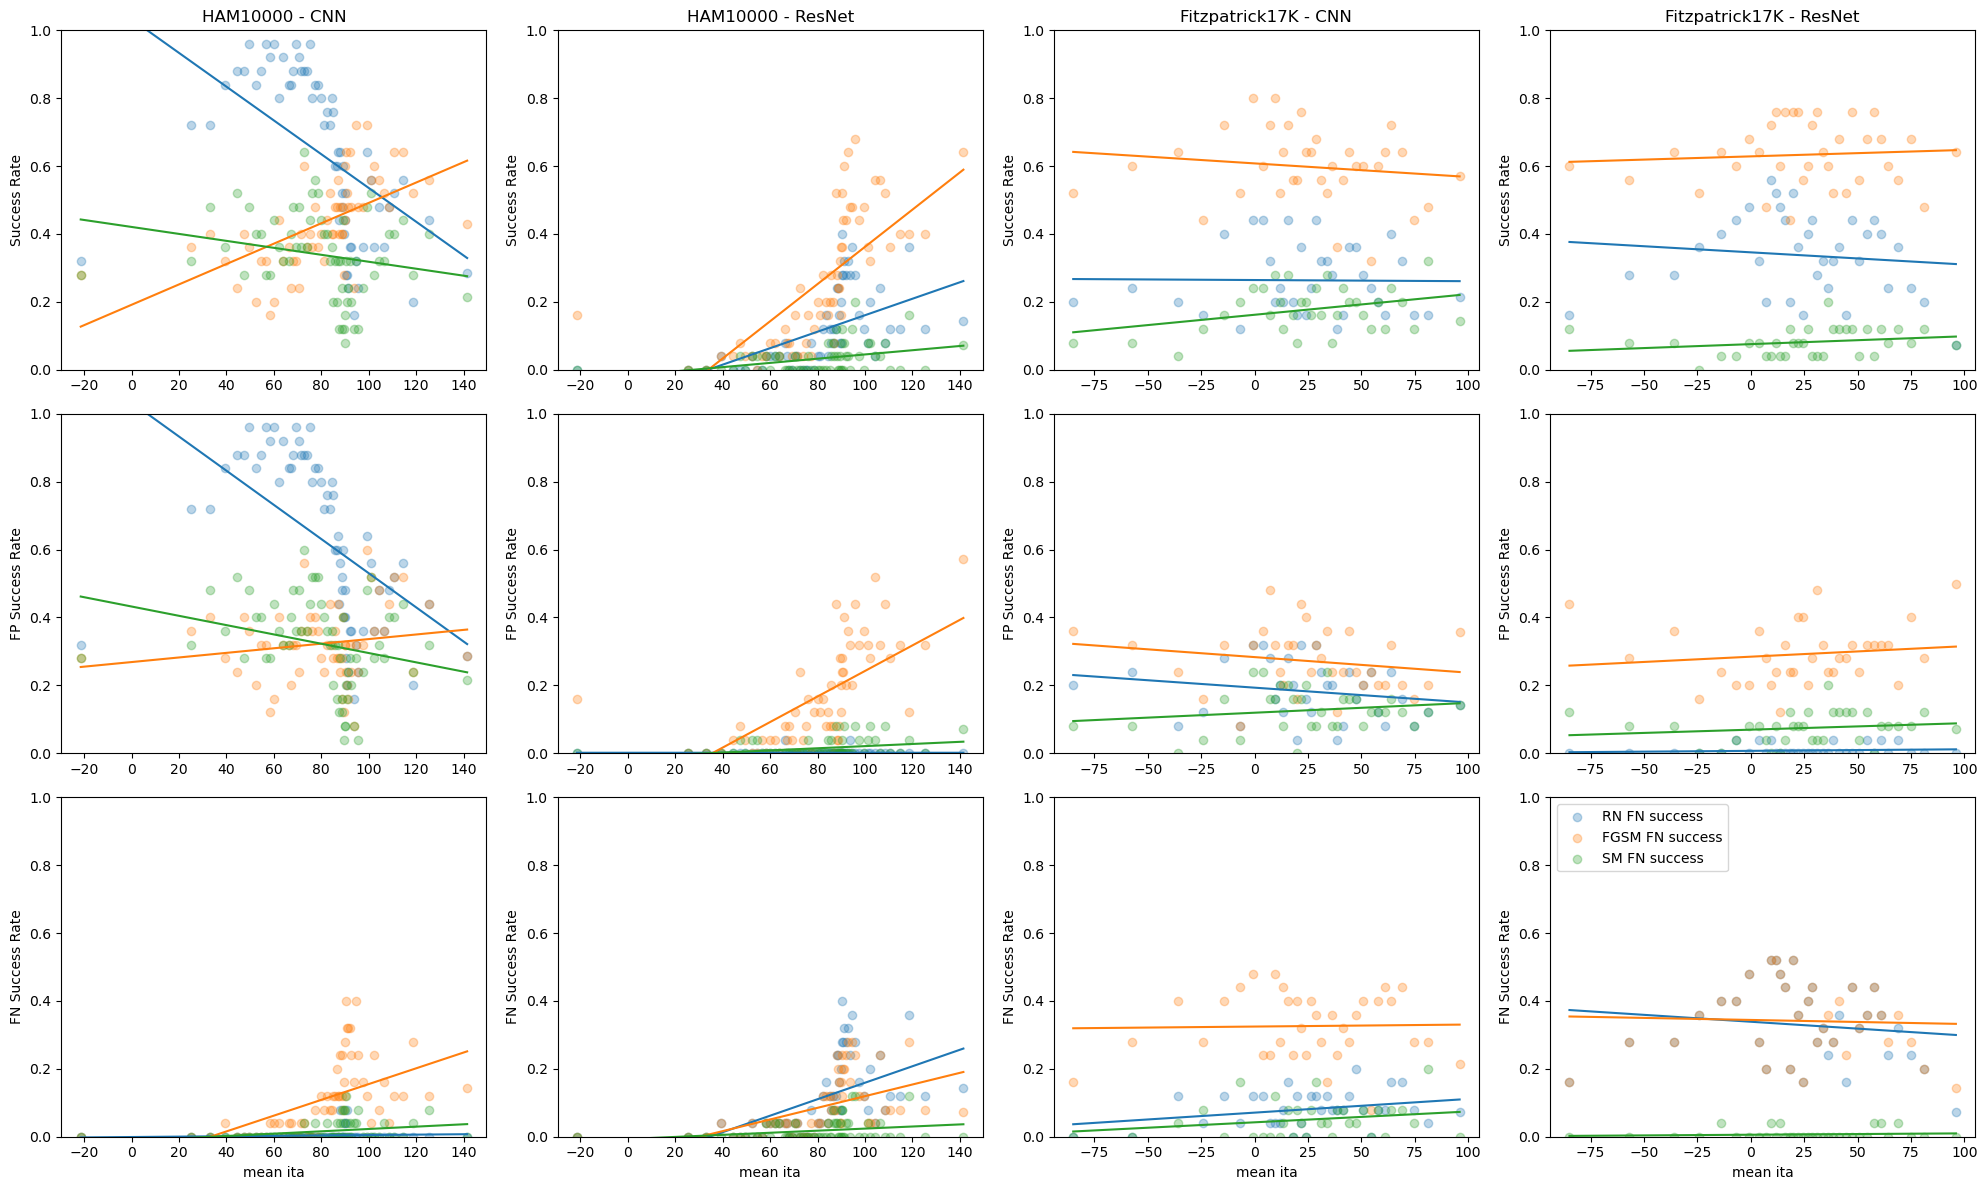

In [16]:
plot_scatter_correlation_with_regression(df_ita_batch, "mean ita")

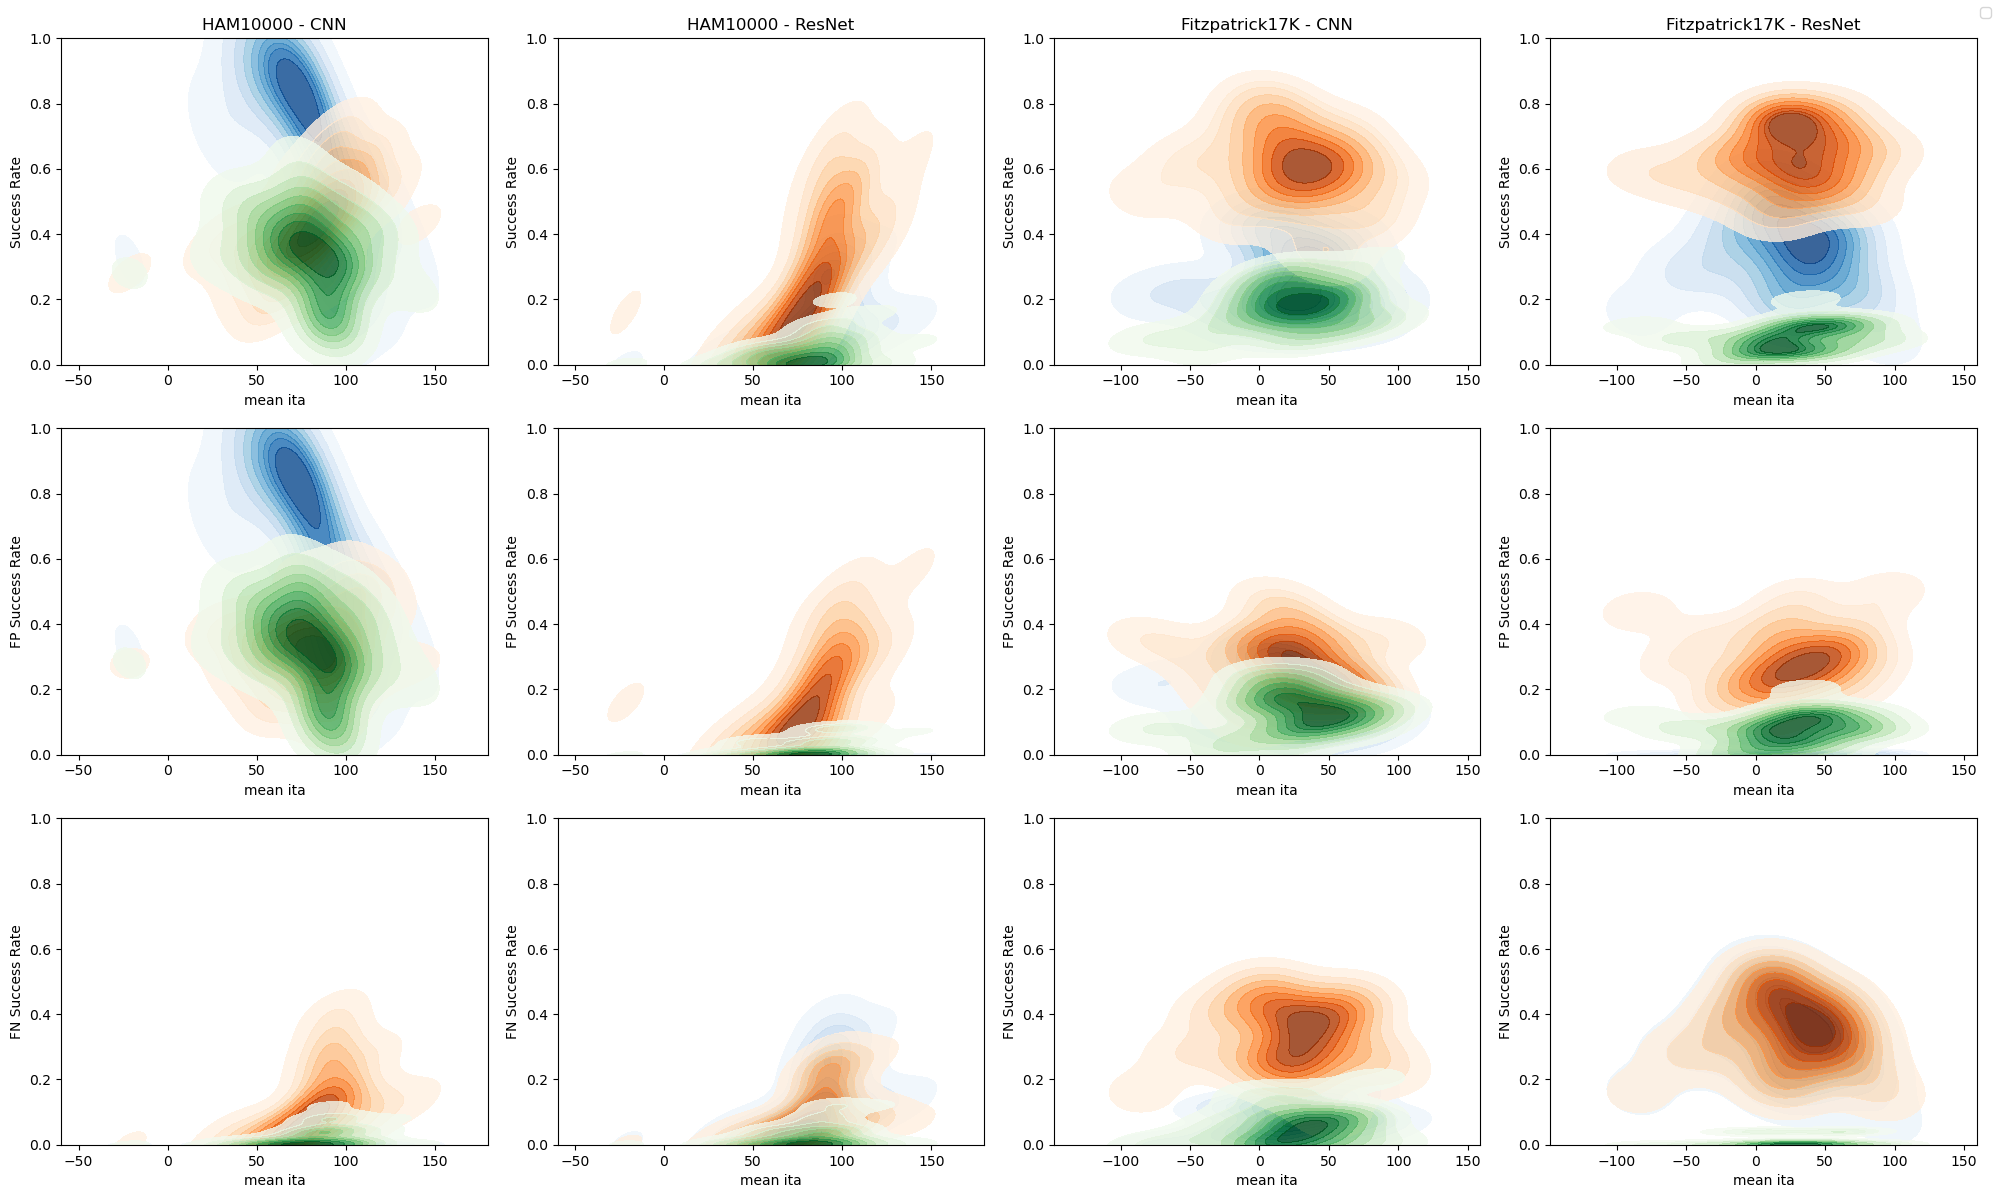

In [17]:
plot_kde_correlation(df_ita_batch, "mean ita")

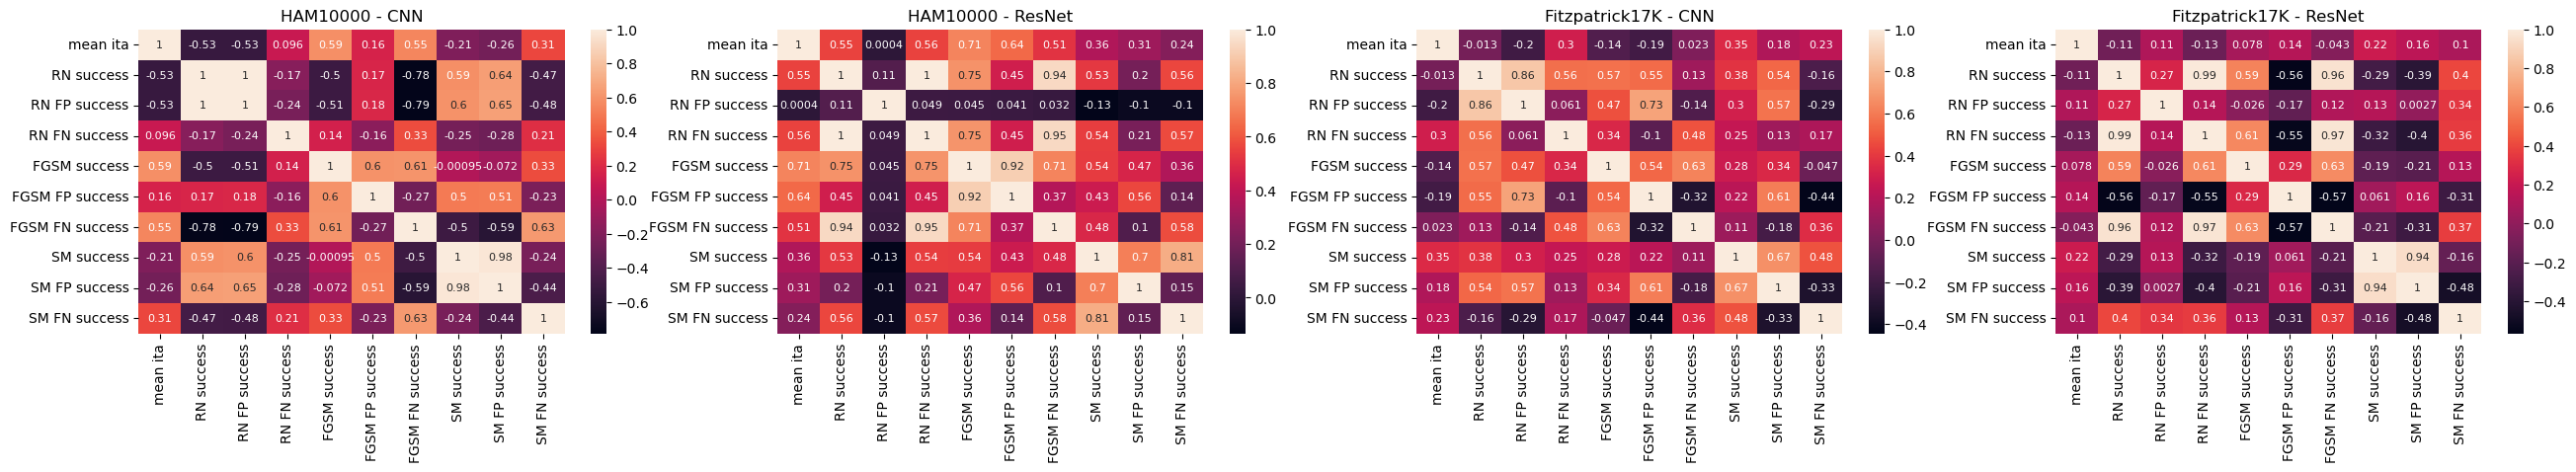

In [18]:
plot_correlation(df_ita_batch, "mean ita")

In [19]:
plot_correlation_dataframe(df_ita_batch, "mean ita")

HAM10000 - CNN


,mean ita,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
mean ita,1.000000,-0.525886,-0.525100,0.095739,0.587166,0.160563,0.547382,-0.211854,-0.262452,0.310011
RN success,-0.525886,1.000000,0.998012,-0.174347,-0.504314,0.170162,-0.775999,0.587062,0.644499,-0.470839
RN FP success,-0.525100,0.998012,1.000000,-0.236056,-0.506938,0.178191,-0.787127,0.595510,0.653894,-0.478180
RN FN success,0.095739,-0.174347,-0.236056,1.000000,0.144580,-0.160390,0.333273,-0.252586,-0.279182,0.211415
FGSM success,0.587166,-0.504314,-0.506938,0.144580,1.000000,0.600231,0.607816,-0.000948,-0.072121,0.334142
FGSM FP success,0.160563,0.170162,0.178191,-0.160390,0.600231,1.000000,-0.270295,0.499198,0.510956,-0.226442
FGSM FN success,0.547382,-0.775999,-0.787127,0.333273,0.607816,-0.270295,1.000000,-0.496751,-0.594098,0.627032
SM success,-0.211854,0.587062,0.595510,-0.252586,-0.000948,0.499198,-0.496751,1.000000,0.978364,-0.241663
SM FP success,-0.262452,0.644499,0.653894,-0.279182,-0.072121,0.510956,-0.594098,0.978364,1.000000,-0.437194
SM FN success,0.310011,-0.470839,-0.478180,0.211415,0.334142,-0.226442,0.627032,-0.241663,-0.437194,1.000000


HAM10000 - ResNet


,mean ita,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
mean ita,1.000000,0.553695,0.000399,0.556519,0.710058,0.644491,0.514424,0.359240,0.310129,0.244305
RN success,0.553695,1.000000,0.112211,0.997992,0.747510,0.449218,0.942639,0.529814,0.204678,0.564979
RN FP success,0.000399,0.112211,1.000000,0.049042,0.045135,0.041148,0.032383,-0.133558,-0.102045,-0.101563
RN FN success,0.556519,0.997992,0.049042,1.000000,0.748479,0.448906,0.945424,0.541053,0.212236,0.574360
FGSM success,0.710058,0.747510,0.045135,0.748479,1.000000,0.915568,0.710647,0.535416,0.469819,0.357961
FGSM FP success,0.644491,0.449218,0.041148,0.448906,0.915568,1.000000,0.367704,0.434192,0.561880,0.143784
FGSM FN success,0.514424,0.942639,0.032383,0.945424,0.710647,0.367704,1.000000,0.478489,0.103428,0.576195
SM success,0.359240,0.529814,-0.133558,0.541053,0.535416,0.434192,0.478489,1.000000,0.697497,0.814343
SM FP success,0.310129,0.204678,-0.102045,0.212236,0.469819,0.561880,0.103428,0.697497,1.000000,0.152105
SM FN success,0.244305,0.564979,-0.101563,0.574360,0.357961,0.143784,0.576195,0.814343,0.152105,1.000000


Fitzpatrick17K - CNN


,mean ita,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
mean ita,1.000000,-0.012889,-0.198741,0.296328,-0.137496,-0.192120,0.023026,0.346058,0.176814,0.231003
RN success,-0.012889,1.000000,0.859577,0.562713,0.565942,0.552372,0.126128,0.380935,0.540531,-0.155684
RN FP success,-0.198741,0.859577,1.000000,0.061271,0.473989,0.730349,-0.142436,0.302454,0.573743,-0.294961
RN FN success,0.296328,0.562713,0.061271,1.000000,0.338654,-0.102563,0.476779,0.254781,0.127649,0.173069
FGSM success,-0.137496,0.565942,0.473989,0.338654,1.000000,0.540571,0.626351,0.280228,0.340972,-0.047370
FGSM FP success,-0.192120,0.552372,0.730349,-0.102563,0.540571,1.000000,-0.317239,0.217755,0.609155,-0.444764
FGSM FN success,0.023026,0.126128,-0.142436,0.476779,0.626351,-0.317239,1.000000,0.114115,-0.180082,0.358717
SM success,0.346058,0.380935,0.302454,0.254781,0.280228,0.217755,0.114115,1.000000,0.671195,0.477583
SM FP success,0.176814,0.540531,0.573743,0.127649,0.340972,0.609155,-0.180082,0.671195,1.000000,-0.330728
SM FN success,0.231003,-0.155684,-0.294961,0.173069,-0.047370,-0.444764,0.358717,0.477583,-0.330728,1.000000


Fitzpatrick17K - ResNet


,mean ita,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
mean ita,1.000000,-0.114238,0.109145,-0.132649,0.078495,0.135171,-0.042502,0.217705,0.160259,0.099655
RN success,-0.114238,1.000000,0.267038,0.990958,0.591493,-0.555601,0.960807,-0.290070,-0.391038,0.396921
RN FP success,0.109145,0.267038,1.000000,0.135323,-0.025577,-0.169272,0.115761,0.131580,0.002722,0.341144
RN FN success,-0.132649,0.990958,0.135323,1.000000,0.611698,-0.547667,0.971724,-0.316551,-0.402419,0.360592
FGSM success,0.078495,0.591493,-0.025577,0.611698,1.000000,0.287065,0.626331,-0.186904,-0.211124,0.133890
FGSM FP success,0.135171,-0.555601,-0.169272,-0.547667,0.287065,1.000000,-0.566949,0.060856,0.158016,-0.309992
FGSM FN success,-0.042502,0.960807,0.115761,0.971724,0.626331,-0.566949,1.000000,-0.210253,-0.310150,0.367413
SM success,0.217705,-0.290070,0.131580,-0.316551,-0.186904,0.060856,-0.210253,1.000000,0.943736,-0.161765
SM FP success,0.160259,-0.391038,0.002722,-0.402419,-0.211124,0.158016,-0.310150,0.943736,1.000000,-0.479007
SM FN success,0.099655,0.396921,0.341144,0.360592,0.133890,-0.309992,0.367413,-0.161765,-0.479007,1.000000


## Multi-dementional array skin nuance

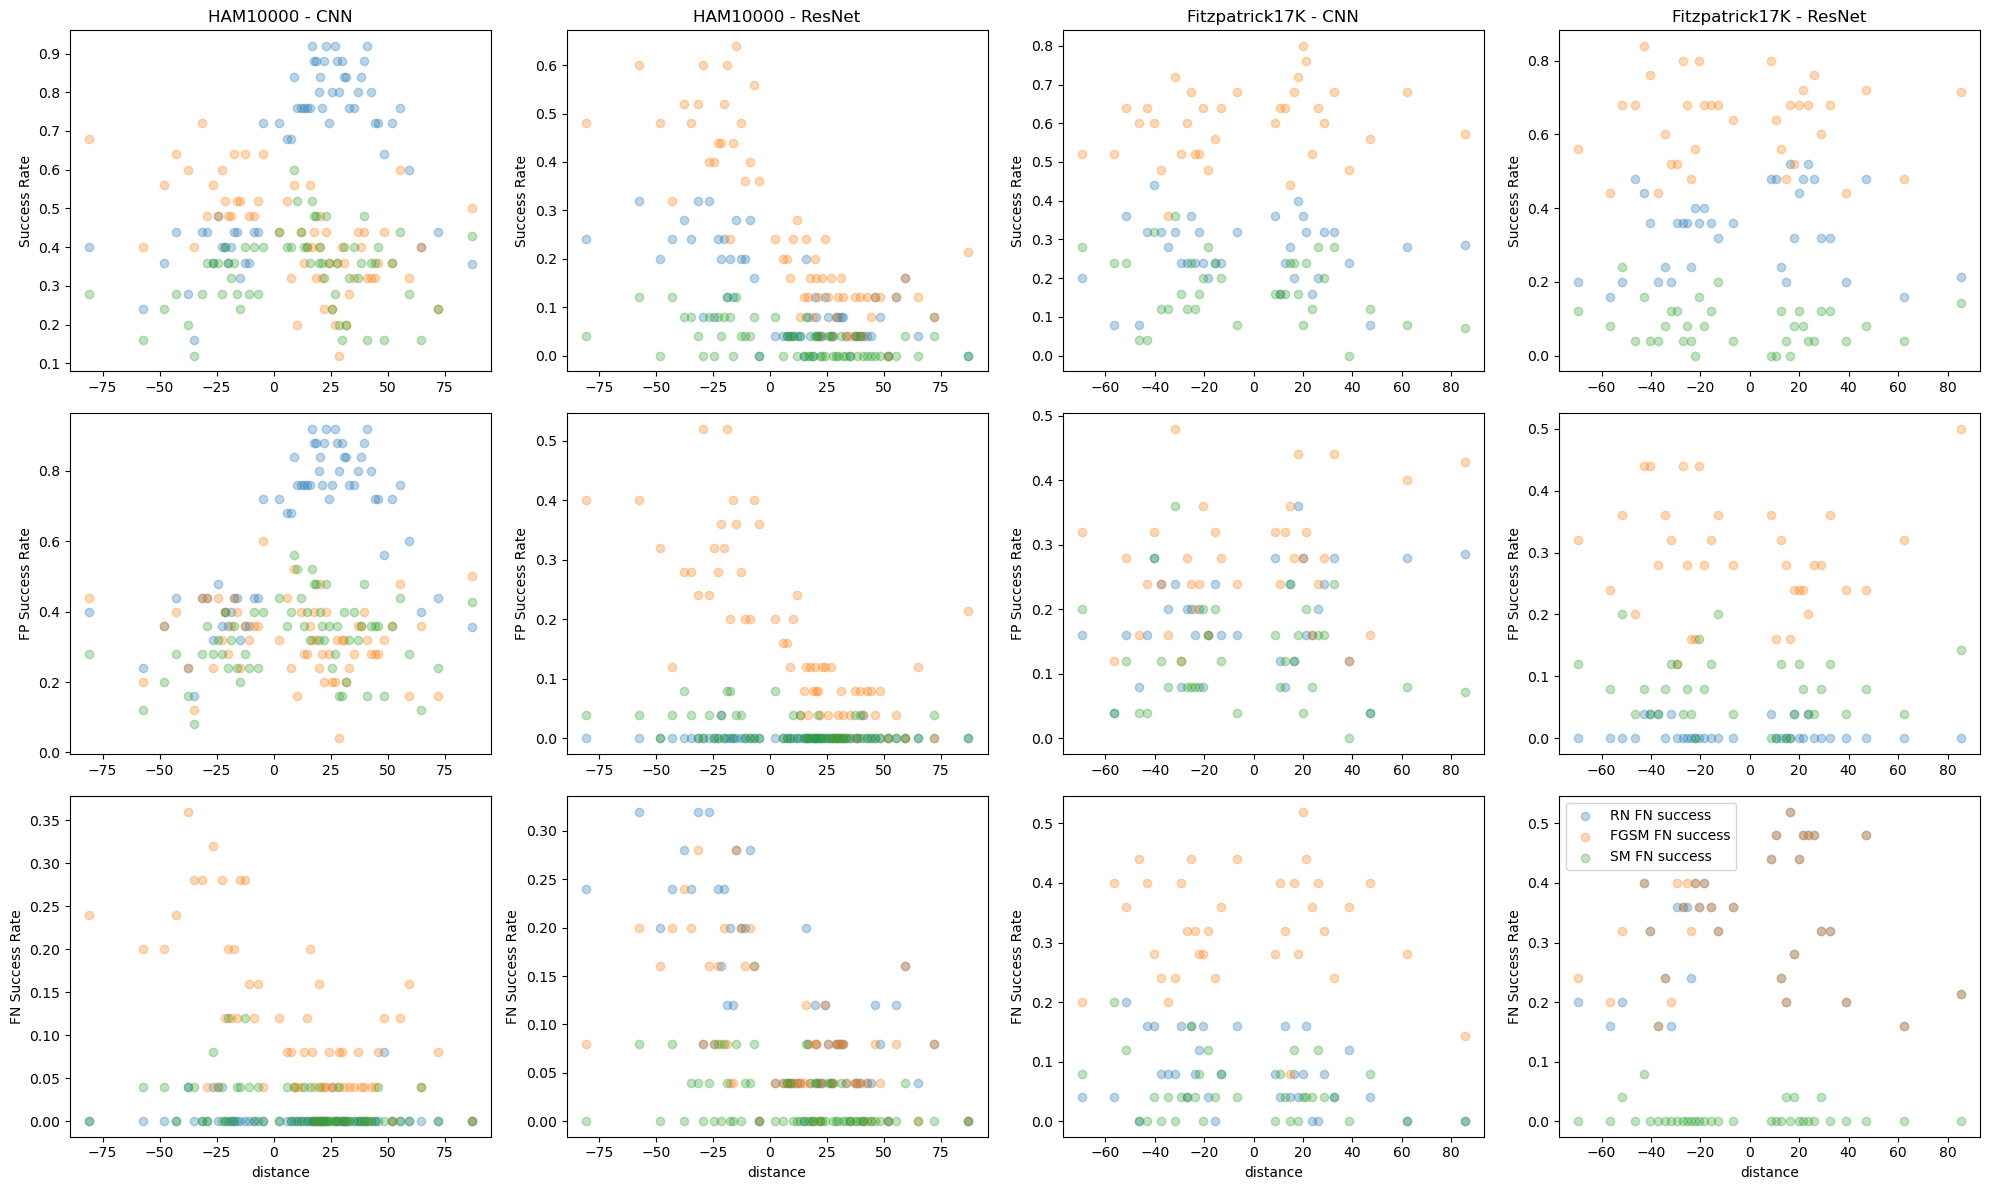

In [20]:
plot_scatter_correlation(df_distance_batch, "distance")

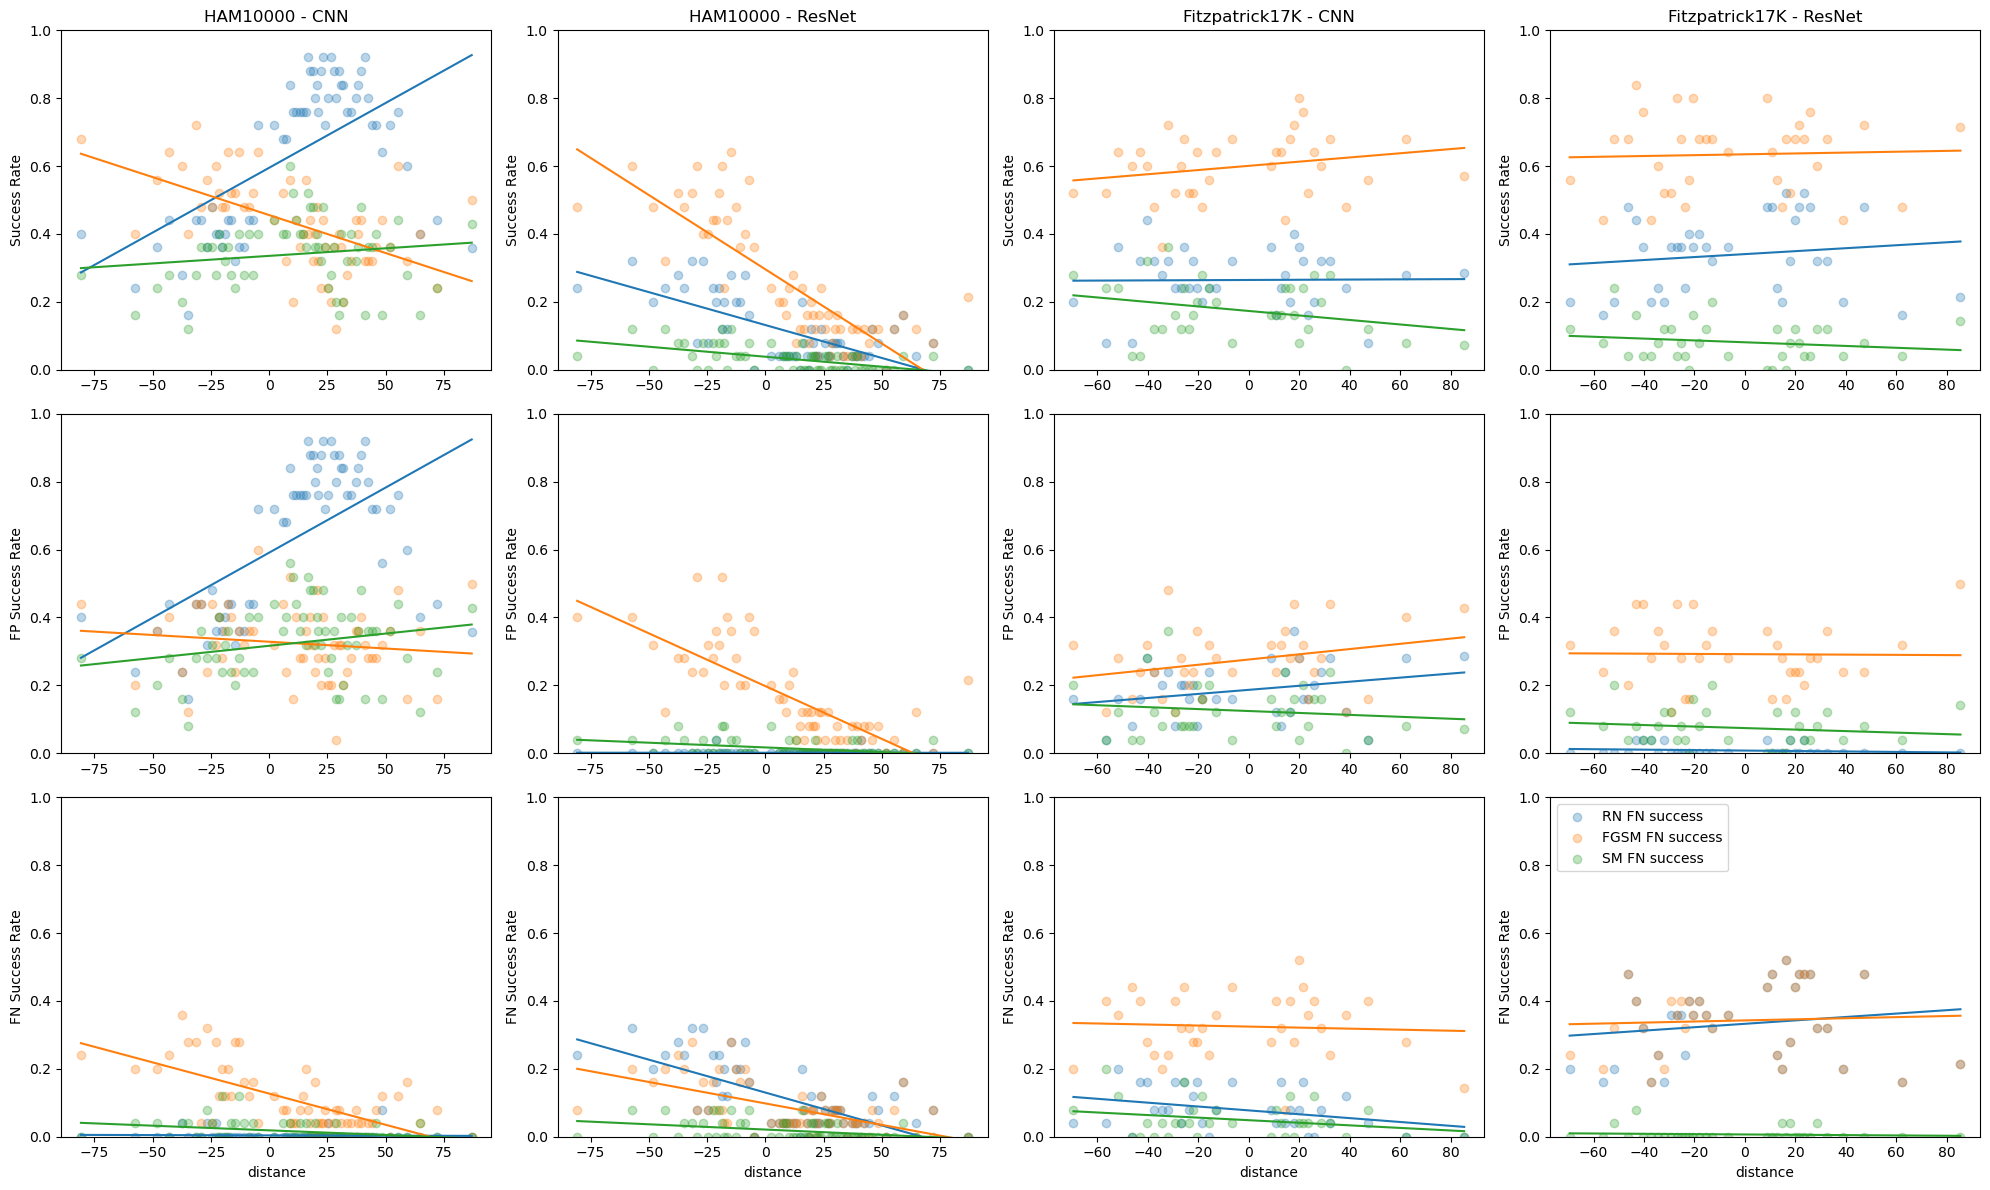

In [21]:
plot_scatter_correlation_with_regression(df_distance_batch, "distance")

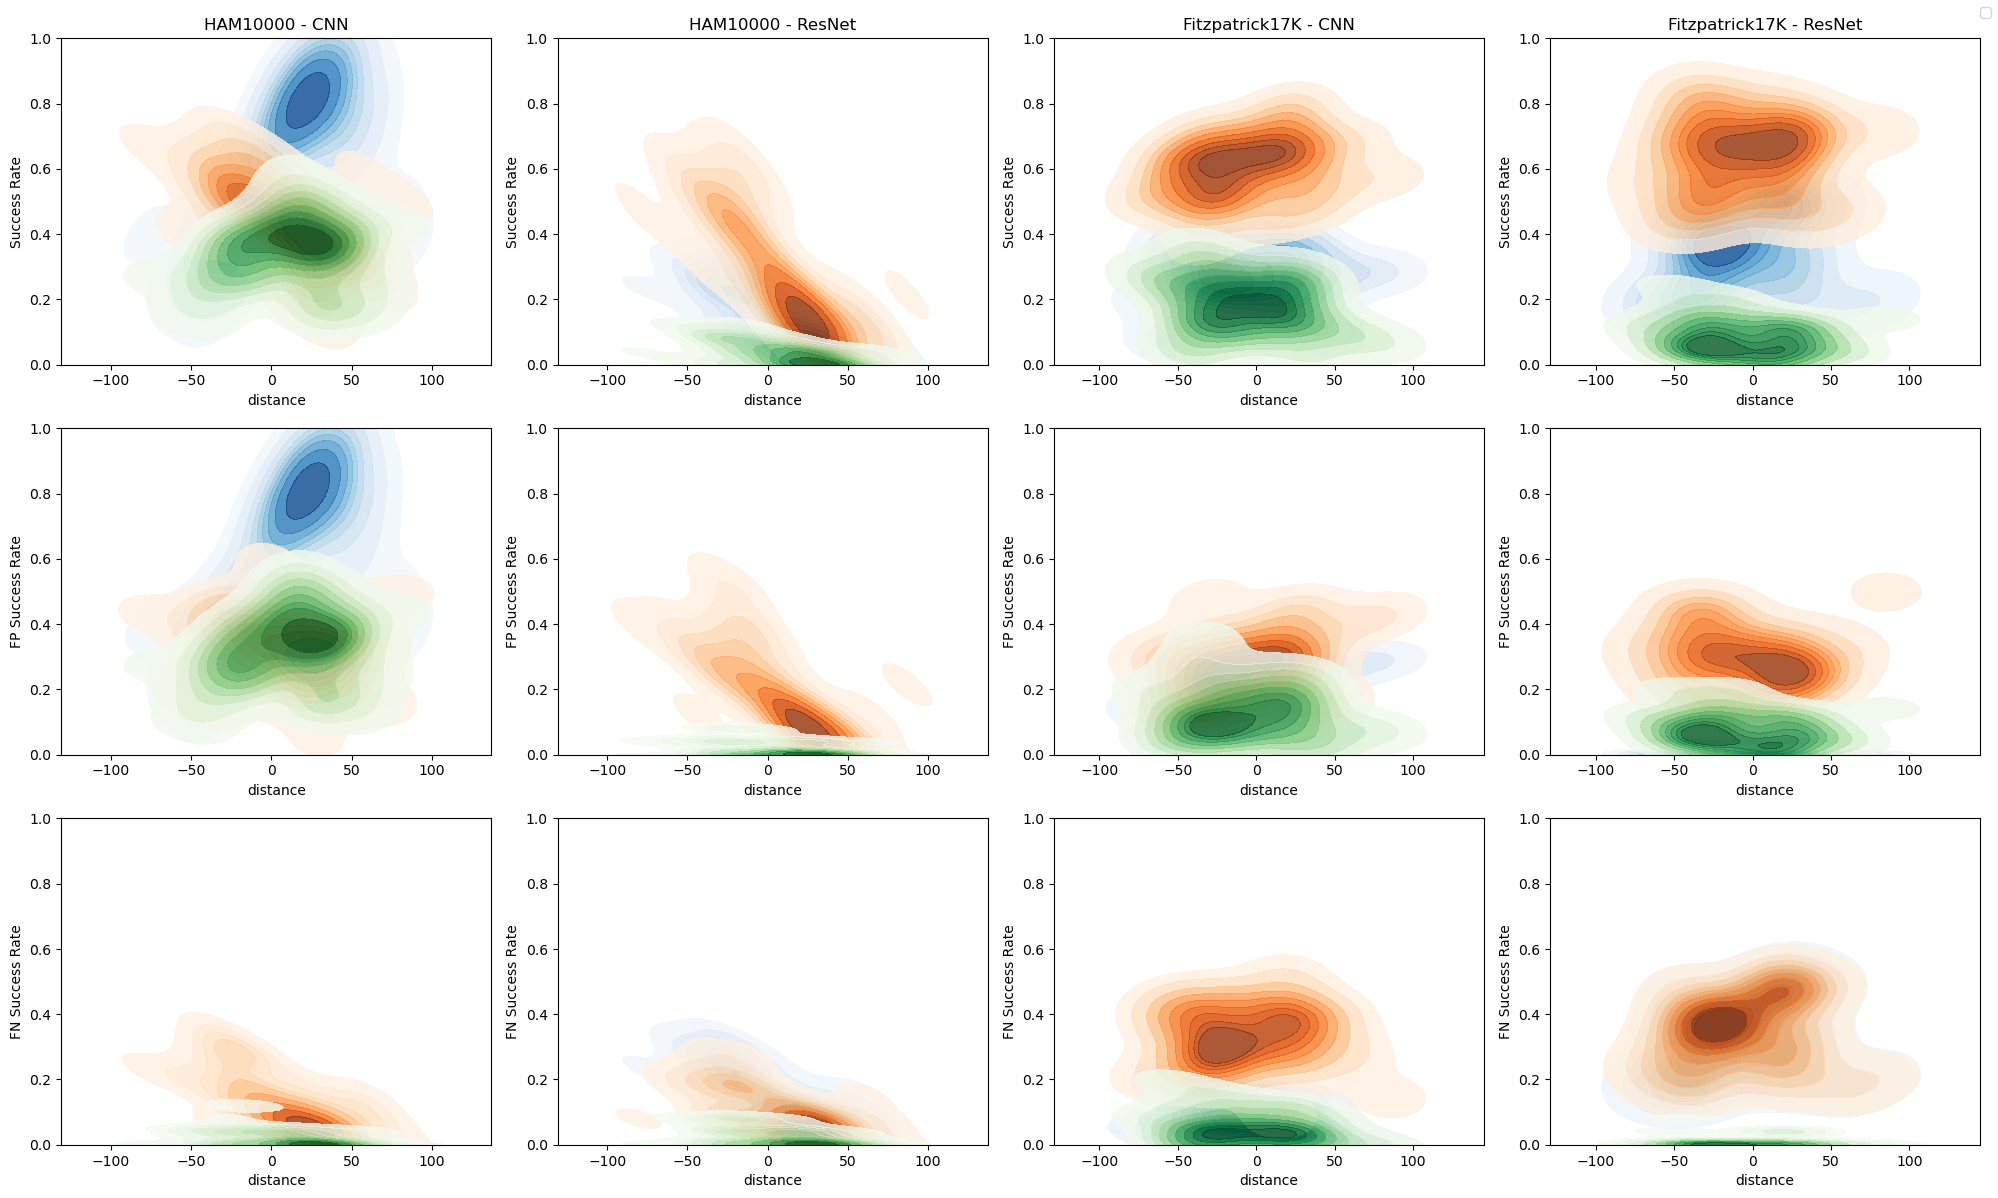

In [22]:
plot_kde_correlation(df_distance_batch, "distance")

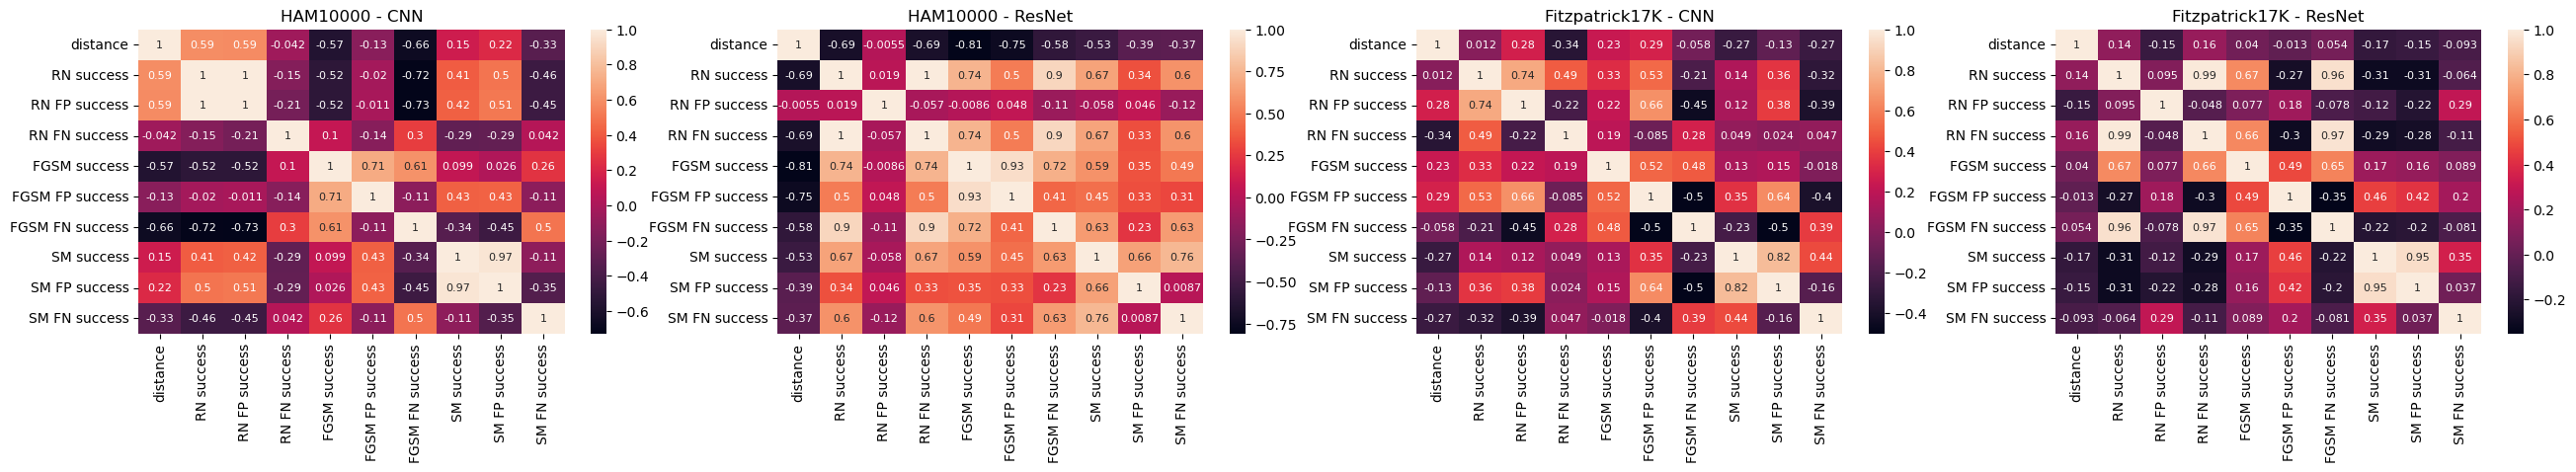

In [23]:
plot_correlation(df_distance_batch, "distance")

In [24]:
plot_correlation_dataframe(df_distance_batch, "distance")

HAM10000 - CNN


,distance,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
distance,1.000000,0.589622,0.585475,-0.041636,-0.570165,-0.127994,-0.664146,0.146455,0.222039,-0.332578
RN success,0.589622,1.000000,0.998032,-0.150477,-0.521303,-0.019809,-0.716645,0.408075,0.499530,-0.456596
RN FP success,0.585475,0.998032,1.000000,-0.212169,-0.521889,-0.010905,-0.727498,0.422008,0.511979,-0.454011
RN FN success,-0.041636,-0.150477,-0.212169,1.000000,0.103866,-0.136798,0.301193,-0.293746,-0.286949,0.042119
FGSM success,-0.570165,-0.521303,-0.521889,0.103866,1.000000,0.713315,0.614657,0.098774,0.026500,0.261970
FGSM FP success,-0.127994,-0.019809,-0.010905,-0.136798,0.713315,1.000000,-0.114378,0.425390,0.429020,-0.114155
FGSM FN success,-0.664146,-0.716645,-0.727498,0.301193,0.614657,-0.114378,1.000000,-0.338761,-0.445295,0.499820
SM success,0.146455,0.408075,0.422008,-0.293746,0.098774,0.425390,-0.338761,1.000000,0.967728,-0.107363
SM FP success,0.222039,0.499530,0.511979,-0.286949,0.026500,0.429020,-0.445295,0.967728,1.000000,-0.354438
SM FN success,-0.332578,-0.456596,-0.454011,0.042119,0.261970,-0.114155,0.499820,-0.107363,-0.354438,1.000000


HAM10000 - ResNet


,distance,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
distance,1.000000,-0.690533,-0.005519,-0.689118,-0.809948,-0.753111,-0.583205,-0.533720,-0.386761,-0.374014
RN success,-0.690533,1.000000,0.018574,0.997153,0.744624,0.503682,0.895700,0.667156,0.335933,0.595714
RN FP success,-0.005519,0.018574,1.000000,-0.056877,-0.008599,0.047689,-0.112296,-0.058348,0.045876,-0.117495
RN FN success,-0.689118,0.997153,-0.056877,1.000000,0.744195,0.499357,0.902874,0.670592,0.331987,0.603714
FGSM success,-0.809948,0.744624,-0.008599,0.744195,1.000000,0.930895,0.718015,0.594616,0.348489,0.488291
FGSM FP success,-0.753111,0.503682,0.047689,0.499357,0.930895,1.000000,0.414147,0.448775,0.334204,0.306667
FGSM FN success,-0.583205,0.895700,-0.112296,0.902874,0.718015,0.414147,1.000000,0.626538,0.231552,0.632377
SM success,-0.533720,0.667156,-0.058348,0.670592,0.594616,0.448775,0.626538,1.000000,0.659633,0.757268
SM FP success,-0.386761,0.335933,0.045876,0.331987,0.348489,0.334204,0.231552,0.659633,1.000000,0.008653
SM FN success,-0.374014,0.595714,-0.117495,0.603714,0.488291,0.306667,0.632377,0.757268,0.008653,1.000000


Fitzpatrick17K - CNN


,distance,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
distance,1.000000,0.012439,0.276098,-0.341778,0.233692,0.287300,-0.058034,-0.274873,-0.129041,-0.268292
RN success,0.012439,1.000000,0.741986,0.486294,0.332110,0.529264,-0.206195,0.144633,0.361053,-0.315698
RN FP success,0.276098,0.741986,1.000000,-0.224982,0.221304,0.655625,-0.447238,0.123447,0.384061,-0.387736
RN FN success,-0.341778,0.486294,-0.224982,1.000000,0.194240,-0.085301,0.283235,0.049310,0.024172,0.046535
FGSM success,0.233692,0.332110,0.221304,0.194240,1.000000,0.515588,0.481713,0.127385,0.151153,-0.018032
FGSM FP success,0.287300,0.529264,0.655625,-0.085301,0.515588,1.000000,-0.502505,0.351511,0.639455,-0.396294
FGSM FN success,-0.058034,-0.206195,-0.447238,0.283235,0.481713,-0.502505,1.000000,-0.230972,-0.501484,0.387115
SM success,-0.274873,0.144633,0.123447,0.049310,0.127385,0.351511,-0.230972,1.000000,0.816309,0.435499
SM FP success,-0.129041,0.361053,0.384061,0.024172,0.151153,0.639455,-0.501484,0.816309,1.000000,-0.164462
SM FN success,-0.268292,-0.315698,-0.387736,0.046535,-0.018032,-0.396294,0.387115,0.435499,-0.164462,1.000000


Fitzpatrick17K - ResNet


,distance,RN success,RN FP success,RN FN success,FGSM success,FGSM FP success,FGSM FN success,SM success,SM FP success,SM FN success
distance,1.000000,0.137049,-0.147810,0.158624,0.039827,-0.013457,0.054377,-0.168696,-0.148557,-0.093378
RN success,0.137049,1.000000,0.094782,0.989839,0.672044,-0.273901,0.958315,-0.307486,-0.306454,-0.063886
RN FP success,-0.147810,0.094782,1.000000,-0.047733,0.077078,0.184758,-0.078279,-0.116558,-0.220965,0.288083
RN FN success,0.158624,0.989839,-0.047733,1.000000,0.663304,-0.301217,0.972733,-0.291876,-0.275927,-0.105251
FGSM success,0.039827,0.672044,0.077078,0.663304,1.000000,0.485389,0.648604,0.173344,0.155136,0.088540
FGSM FP success,-0.013457,-0.273901,0.184758,-0.301217,0.485389,1.000000,-0.350627,0.460781,0.423550,0.202077
FGSM FN success,0.054377,0.958315,-0.078279,0.972733,0.648604,-0.350627,1.000000,-0.215457,-0.202548,-0.081078
SM success,-0.168696,-0.307486,-0.116558,-0.291876,0.173344,0.460781,-0.215457,1.000000,0.949265,0.348956
SM FP success,-0.148557,-0.306454,-0.220965,-0.275927,0.155136,0.423550,-0.202548,0.949265,1.000000,0.036543
SM FN success,-0.093378,-0.063886,0.288083,-0.105251,0.088540,0.202077,-0.081078,0.348956,0.036543,1.000000


In [42]:
for _, row in unique_combinations.iterrows():
    model = row["model"]
    dataset = row["dataset"]

    tmp1 = df_ita_batch[["model", "dataset", "mean ita"]][(df_ita_batch["model"] == model) & (df_ita_batch["dataset"] == dataset)]
    tmp2 = df_distance_batch[["model", "dataset", "distance"]][(df_distance_batch["model"] == model) & (df_distance_batch["dataset"] == dataset)]

    df_distance_ita = pd.concat([tmp1, tmp2], axis=1)
    df_distance_ita = df_distance_ita.loc[:,~df_distance_ita.columns.duplicated()]
    print(df_distance_ita[["mean ita", "distance"]].corr())

          mean ita  distance
mean ita  1.000000  0.977031
distance  0.977031  1.000000
          mean ita  distance
mean ita  1.000000  0.977031
distance  0.977031  1.000000
          mean ita  distance
mean ita  1.000000  0.947392
distance  0.947392  1.000000
          mean ita  distance
mean ita  1.000000  0.947392
distance  0.947392  1.000000
